In [ ]:
##the following below shows how to present the data to the athletic trainers

In [ ]:
#the following code uses the above as a guide and implements ML 

Shape of X: (200, 2)
Shape of y_true: (200,)
Length of y_pred: 200
Lengths match, proceeding with evaluation.
Confusion Matrix:
 [[100   0]
 [ 14  86]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       100
           1       1.00      0.86      0.92       100

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.93      0.93       200



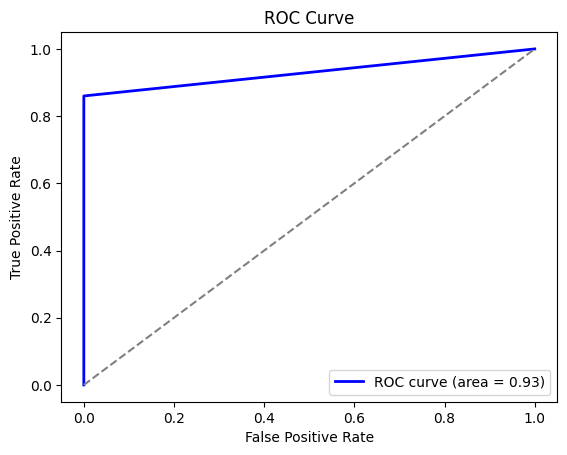

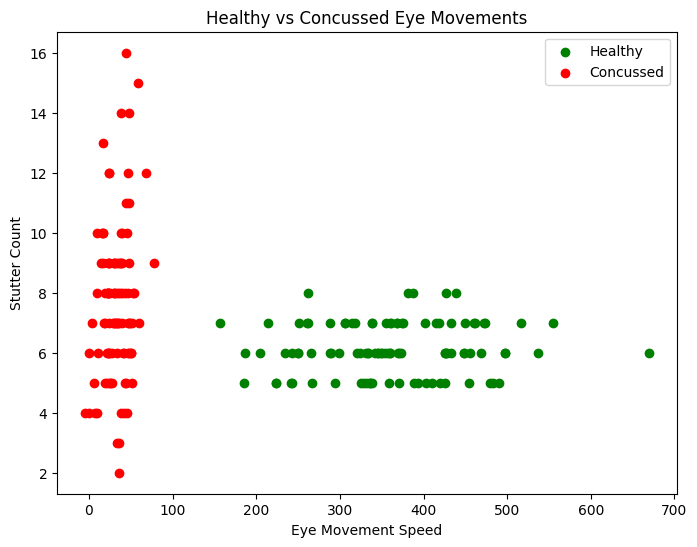


🔹 Patient ID: P22_READ
🧠 Average Saccade Speed: 110.84°/s
📊 Stutter Count: 8.657
🔴 Concussion Likelihood: Unlikely
✅ No significant concussion likelihood detected. Monitor for symptoms.

🔹 Patient ID: P18_READ
🧠 Average Saccade Speed: 26.62°/s
📊 Stutter Count: 16.256
🔴 Concussion Likelihood: Likely
⚠️ Likely concussed. Recommend further medical evaluation.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import os
import random

# Function to load data
def load_data(input_dir):
    data_frames = {}
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv") and "_READ" in file:
                file_path = os.path.join(root, file)
                person_id = file.replace(".csv", "")
                data_frames[person_id] = pd.read_csv(file_path)
    return data_frames
    
# Generate synthetic data
def generate_healthy_data(n=100, viewing_angle="narrow"):
    # Narrow viewing angle: average speed = 349.31 ± 97.90°/s
    # Wide viewing angle: average speed = 448.95 ± 143.94°/s
    if viewing_angle == "narrow":
        speeds = np.random.normal(loc=349.31, scale=97.90, size=n)  # Narrow angle speeds
    elif viewing_angle == "wide":
        speeds = np.random.normal(loc=448.95, scale=143.94, size=n)  # Wide angle speeds
    stutter_counts = np.array([7, 6, 8, 5, 7, 6, 6, 7, 5, 6, 7, 5, 6, 6, 5, 7, 6, 6, 5, 7])  # Threshold tutter counts decided with trainer
    return speeds, np.tile(stutter_counts, n // len(stutter_counts))

# Generate concussed data
def generate_concussed_data(n=100):
    speeds = np.random.normal(loc=30, scale=15, size=n)  # Reduced speed for concussed
    stutter_counts = np.random.poisson(lam=8, size=n)  # Increased stutter count for concussed
    return speeds, stutter_counts

# Concussion likelihood model
def concussion_likelihood(speed, stutter_count):
    likelihood = (stutter_count * 0.6) + ((50 - speed) * 0.4)  # Weighted formula
    return likelihood > 5  # Returns True if likely concussed

def calculate_saccade_speed(data):
    data['x'] = pd.to_numeric(data['x'], errors='coerce')
    data['y'] = pd.to_numeric(data['y'], errors='coerce')
    data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['x', 'y', 'timestamp'])
    data['saccade_speed'] = np.sqrt((data['x'].diff() ** 2) + (data['y'].diff() ** 2)) / data['timestamp'].diff()
    data['saccade_speed'] = data['saccade_speed'].fillna(0)
    return data

# Combine healthy and concussed data for training model
healthy_speeds, healthy_stutters = generate_healthy_data(100)
concussed_speeds, concussed_stutters = generate_concussed_data(100)

# Create labeled dataset (200 samples)
X = np.concatenate([np.column_stack([healthy_speeds, healthy_stutters]),
                    np.column_stack([concussed_speeds, concussed_stutters])])

y_true = np.array([0] * 100 + [1] * 100)  # 0 = Healthy, 1 = Concussed

# Debugging: Print shapes to verify the data sizes
print(f"Shape of X: {X.shape}")
print(f"Shape of y_true: {y_true.shape}")

# Apply model to each row in X and generate y_pred (correct number of samples)
y_pred = np.array([concussion_likelihood(speed, stutter) for speed, stutter in X])

# Debugging: Print the length of y_pred to ensure it matches y_true
print(f"Length of y_pred: {len(y_pred)}")

# Check if lengths match
if len(y_true) != len(y_pred):
    print(f"Mismatch! y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} samples.")
else:
    print("Lengths match, proceeding with evaluation.")

# Evaluation Metrics
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Visualization of Data
plt.figure(figsize=(8, 6))
plt.scatter(healthy_speeds, healthy_stutters, color='green', label='Healthy')
plt.scatter(concussed_speeds, concussed_stutters, color='red', label='Concussed')
plt.xlabel('Eye Movement Speed')
plt.ylabel('Stutter Count')
plt.title('Healthy vs Concussed Eye Movements')
plt.legend()
plt.show()

# Simulated concussion likelihood for a random patient
def simulate_patient(input_dir, mock_unhealthy=False):
    data_frames = load_data(input_dir)
    
    # Randomly select a patient
    patient_id = random.choice(list(data_frames.keys()))
    patient_data = data_frames[patient_id]
    
    # Calculate average speed and stutter count
    patient_data = calculate_saccade_speed(patient_data)
    avg_speed = patient_data['saccade_speed'].mean() * 100
    stutter_count = len(patient_data[patient_data['saccade_speed'] < 10]) / 1000  # Stutter threshold
    
    # If we are mocking unhealthy data, reduce speed and increase stutters
    if mock_unhealthy:
        avg_speed = avg_speed * 0.3  # Reduce speed to simulate concussed data
        stutter_count = stutter_count * 2  # Increase stutter count to simulate concussed data
    
    # Calculate concussion likelihood
    likelihood = concussion_likelihood(avg_speed, stutter_count)
    
    # Provide trainer with an explanation of the result
    print(f"\n🔹 Patient ID: {patient_id}")
    print(f"🧠 Average Saccade Speed: {avg_speed:.2f}°/s")
    print(f"📊 Stutter Count: {stutter_count}")
    print(f"🔴 Concussion Likelihood: {'Likely' if likelihood else 'Unlikely'}")
    
    # Provide trainer with decision based on likelihood
    if likelihood:
        print("⚠️ Likely concussed. Recommend further medical evaluation.")
    else:
        print("✅ No significant concussion likelihood detected. Monitor for symptoms.")


# Simulate a random patient test
# Simulate a random healthy patient with a mock unhealthy state
simulate_patient("/kaggle/input/eye-movement-data-set-for-desktop-activities", mock_unhealthy=False)
# Simulate a random healthy patient with a mock unhealthy state
simulate_patient("/kaggle/input/eye-movement-data-set-for-desktop-activities", mock_unhealthy=True)